#### Offensive Tweets classification using NLP

Code is fast and scalable

#### Imports

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mapply
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

from common_functions import load_data_from_url, hyperparam_tuning, RANDOM_STATE

nltk.download('stopwords')

np.random.seed(RANDOM_STATE)

# Using df.mapply instead of .apply will make it parallel and much faster
mapply.init(
    n_workers=4,
    chunk_size=100,
    max_chunks_per_worker=8,
    progressbar=False,
)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/praneeth/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Data acquisition

In [2]:
df = load_data_from_url('https://github.com/mapama247/TFM_offensive_tweets_data/raw/master/en19b.tsv', 'tweets.tsv')
df.head()

,id,tweet,lbl
0,86426,@USER She should ask a few native Americans wh...,UNT
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,TIN
2,62688,"\""@USER Someone should'veTaken\""\"" this piece ...",UNT
3,97670,@USER Liberals are all Kookoo !!!,TIN
4,77444,@USER @USER Oh noes! Tough shit.,UNT


Note:
- UNT: Untargeted
- TIN: Targeted Individual
- GRP: Targeted Group

#### Data Transformation & Pre-processing

In [3]:
# Preprocessing
eng_stopwords = stopwords.words('english')
def clean_tweet(tweet):
	tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet)  # Remove Twitter usernames
	tweet = re.sub(r'[^0-9A-Za-z \t]', '', tweet)  # Remove special characters
	tweet = re.sub(r'\w+:\/\/\S+', '', tweet)  # Remove URLs
	tweet = re.sub(r'#', '', tweet)  # Convert hashtags into words - remove the '#' symbol
	tweet = re.sub(r'\d+', '', tweet)  # Remove numbers as they dont add value
	tweet = ' '.join(tweet.split())  # Remove extra spaces
	tweet = tweet.lower()  # Convert to lower case
	# Remove stopwords as they do not add value to the model
	tweet = ' '.join([word for word in tweet.split() if word not in eng_stopwords])
	return tweet
df['cleaned_tweet'] = df['tweet'].mapply(clean_tweet)

# Stemming - "programming", "programmer", and "programs" into "program"
stemmer = PorterStemmer()
df['cleaned_tweet'] = df['cleaned_tweet'].mapply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# remove id, tweet columns
df = df.drop(columns=['id', 'tweet'])

df['lbl'] = df['lbl'].mapply(lambda x: False if x == 'UNT' else True)

df.head()

,lbl,cleaned_tweet
0,False,ask nativ american take
1,True,go home your drunk maga trump url
2,False,someon shouldvetaken piec shit volcano
3,True,liber kookoo
4,False,oh noe tough shit


In [4]:
# Transformation before training

# Converting text to numerical features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned_tweet']).toarray()

# Encoding the labels
encoder = LabelEncoder()
y = encoder.fit_transform(df['lbl'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

print(X[0])

[0. 0. 0. ... 0. 0. 0.]


#### Model building and training

Here, we fit the entire data without splitting training and testing data, as this is NLP

In [5]:
# Training the model
model = LogisticRegression(random_state=RANDOM_STATE)
model.fit(X_train, y_train)
model

LogisticRegression(random_state=42)

In [6]:
# Making predictions
y_pred = model.predict(X_test)
y_pred[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### Model evaluation

In [7]:
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 score: {f1}')

acc_score = accuracy_score(y_test, y_pred)
print(f'Accuracy score: {acc_score}')

F1 score: 0.5010752688172043
Accuracy score: 0.8793103448275862


#### Trying with a balanced model

In [8]:
balanced_model = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE)
balanced_model.fit(X_train, y_train)

y_pred = balanced_model.predict(X_test)

f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1 score: {f1}')

acc_score = accuracy_score(y_test, y_pred)
print(f'Accuracy score: {acc_score}')

F1 score: 0.5893101873001371
Accuracy score: 0.7995689655172413


Note: When you set class_weight to balanced, the algorithm will automatically adjust weights inversely proportional to class frequencies in the input data. This is useful when you deal with imbalanced datasets.

#### Hyperparameter tuning

In [9]:
param_grid = {
	'iterations': [60, 100, 200],
	'class_weight': ['balanced', None],
	'random_state': [RANDOM_STATE],
}
selected_model = hyperparam_tuning(model, X, y, param_grid)
selected_model.fit(X_train, y_train)

y_pred = selected_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')
print(f'\nF1 score: {f1}')

acc_score = accuracy_score(y_test, y_pred)
print(f'Accuracy score: {acc_score}')

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'class_weight': None, 'max_iter': 60, 'random_state': 42}
Best accuracy Score: 0.8814403261553402

F1 score: 0.5010752688172043
Accuracy score: 0.8793103448275862


Note: Hyperparameter tuning did not improve the model's F1 score compared to the balanced model

#### Final model evaluation

##### Confusion matrix

Precision: 0.8826086956521739
Recall: 0.9950980392156863
F1 score: 0.9354838709677419


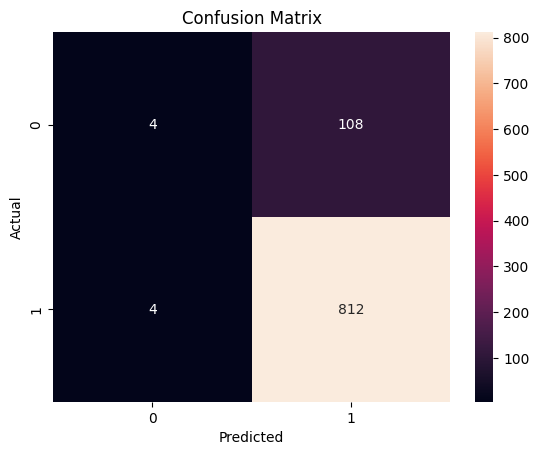

In [10]:
conf_matrix = confusion_matrix(y_test, y_pred)

# find scores based on the confusion matrix
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 score: {f1}')


# Visualizing the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

##### Classification report


Classification report:
              precision    recall  f1-score   support

           0       0.50      0.04      0.07       112
           1       0.88      1.00      0.94       816

    accuracy                           0.88       928
   macro avg       0.69      0.52      0.50       928
weighted avg       0.84      0.88      0.83       928



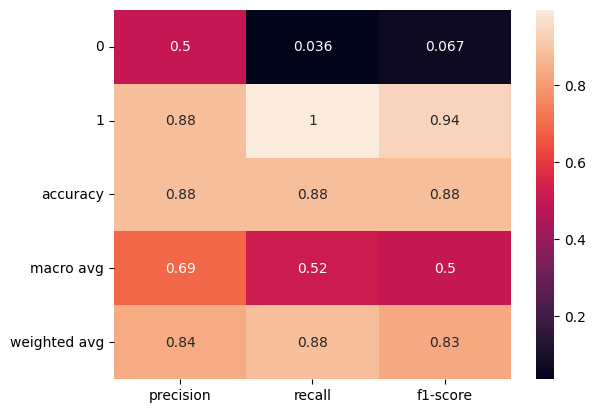

In [11]:
print('\nClassification report:')
print(classification_report(y_test, y_pred))

# Visualize classification report
report = classification_report(y_test, y_pred, output_dict=True)
sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True)
plt.show()

#### Prediction on custom input

In [12]:
def predict_targeted(input_text):
	processed_text = vectorizer.transform([input_text])
	prediction = balanced_model.predict(processed_text)
	predicted_label = encoder.inverse_transform(prediction)
	return predicted_label[0]

predict_targeted("how bad you are")

True

In [13]:
predict_targeted("you are a criminal")

True

In [14]:
predict_targeted("you are good")  # Not offensive, so False

False

## For more projects, open [README.md](/README.md)

___